In [5]:
from nusa import *
from nusa.mesh import *

m = Modeler()
BB, ES = 1, 0.1
nc, ec = m.generate_mesh_from_file(r"src\linear-triangle-element\simple.msh")
m.plot_mesh()
x,y = nc[:,0], nc[:,1]

nodos = []
elementos = []

for k,nd in enumerate(nc):
    cn = Node((x[k],y[k]))
    nodos.append(cn)
    
for k,elm in enumerate(ec):
    i,j,m = int(elm[0]),int(elm[1]),int(elm[2])
    ni,nj,nm = nodos[i],nodos[j],nodos[m]
    ce = LinearTriangle((ni,nj,nm),200e9,0.3,0.25)
    elementos.append(ce)

m = LinearTriangleModel()
for node in nodos: m.add_node(node)
for elm in elementos: m.add_element(elm)
    
# Aplicando condiciones de frontera en los extremos
minx, maxx = min(x), max(x)
miny, maxy = min(y), max(y)

P = 1000 # 100e3/((BB/ES)+1)

for node in nodos:
    if abs(node.x - minx) < 0.05:
        m.add_constraint(node, ux=0, uy=0)
    if abs(node.x - maxx) < 0.15:
        m.add_force(node, (P, P))

m.plot_model()
m.solve()

TypeError: list indices must be integers or slices, not str

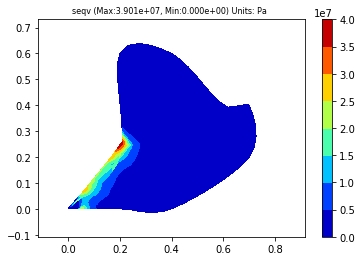

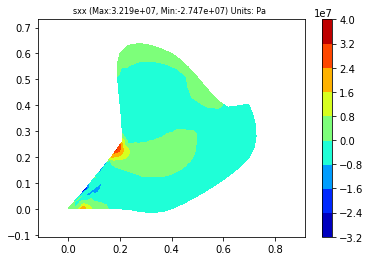

In [2]:
m.plot_nsol("seqv", units="Pa")
m.plot_nsol("sxx", units="Pa")